# Постановка задачи

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами.

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Из сплава выводится сера, добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Предстоит построить прототип модели, которая предскажет конечную температуру стали в партии исходя из данных об объёмах добавленных присадок, проволоки, инертного газа, а также активных и реактивных мощностей.

# План работы

1. Предобработка данных
    1. Необходимо удалить все ключи с 1 записью или имеющие менее 2 замеров температуры.
    2. Выделить стартовую температуру (после первого замера) как фичу, а последнюю как таргет.
    3. Возможно стоит выделить как фичу время нахождения партии в ковше
    4. Сгрупировать таблицу с мощностями с агрегирующей функцией (видимо суммой)
    5. Смерджить все таблицы по ключам
    6. Заполнить пустоты. Булк и вайр вероятно заполнить нулями.
    7. Проверить все фичи на мультиколлинеарность. Взять на заметку фичи с высокой корреляцией.
2. Обучение моделей
    1. Выделить тест и трейн
    2. Обучить модели: CatBoost, XGBoost, LGBMRegressor, LinearRegression
    3. Проверить важность фичей. Попробовать без неважных фичей, вспоминая пункт 1.G.
    4. Обучить несколько моделей. Выбрать лучшую. Подобрать гиперпараметры.
3. Валидация результатов
    1. Проверка модели на адекватность
    2. Выводы графиков обучения модели


# Импорт библиотек. Просмотр данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import time

In [2]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('C:/Users/GrayFox/Downloads/final_steel/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('C:/Users/GrayFox/Downloads/final_steel/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('C:/Users/GrayFox/Downloads/final_steel/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('C:/Users/GrayFox/Downloads/final_steel/final_steel/data_gas.csv')
    data_temp = pd.read_csv('C:/Users/GrayFox/Downloads/final_steel/final_steel/data_temp.csv')
    data_wire = pd.read_csv('C:/Users/GrayFox/Downloads/final_steel/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('C:/Users/GrayFox/Downloads/final_steel/final_steel/data_wire_time.csv')

In [3]:
display(data_arc.head(10))
display(data_arc.describe())
display(data_bulk.head(10))
display(data_bulk.describe())
display(data_bulk_time.head(10))
display(data_bulk_time.describe())
display(data_gas.head(10))
display(data_gas.describe())
display(data_temp.head(10))
display(data_temp.describe())
display(data_wire.head(10))
display(data_wire.describe())
display(data_wire_time.head(10))
display(data_wire_time.describe())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [4]:
def hist_box(column, title, x):
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.hist(column, bins=30)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel('Количество показаний')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.boxplot(column)
    ax.set_title(title + ' Ящик с усами')
    ax.set_ylabel(x)
    plt.show()

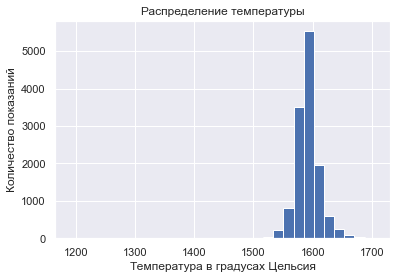

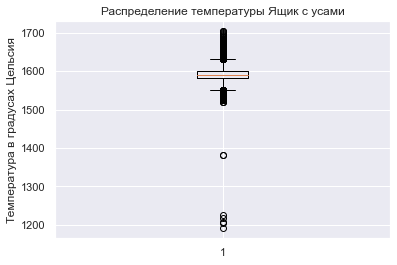

In [5]:
hist_box(data_temp['Температура'].dropna(), 'Распределение температуры', 'Температура в градусах Цельсия')

В таргете есть характерные выбросы с температурой менее 1400 (температура плавления стали 1450+). Вероятно ошибка датчиков. Удалим позже.

In [6]:
display(data_arc[data_arc['Реактивная мощность'] < 0])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


При то что реактивная мощность теоретически может быть отрицательной, порядок совсем другой. Тоже удалим.

In [7]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
322     13
        ..
614      1
1914     1
2025     1
2795     1
1568     1
Name: key, Length: 3214, dtype: int64

Есть ключи с одной строкой замера температуры. Такие нам не подходят. Посмотрим что творится в самой длинной по записям партии.

In [8]:
data_arc[data_arc['key'] == 2108]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9734,2108,2019-07-23 14:05:57,2019-07-23 14:08:12,0.442274,0.327734
9735,2108,2019-07-23 14:32:08,2019-07-23 14:33:35,0.334060,0.273037
9736,2108,2019-07-23 14:38:21,2019-07-23 14:39:16,0.242396,0.171868
9737,2108,2019-07-23 14:40:29,2019-07-23 14:41:29,0.252583,0.191510
9738,2108,2019-07-23 14:44:10,2019-07-23 14:46:08,0.487753,0.375812
9739,2108,2019-07-23 14:47:56,2019-07-23 14:50:51,0.762996,0.580148
9740,2108,2019-07-23 17:04:16,2019-07-23 17:07:58,0.748764,0.573281
9741,2108,2019-07-23 17:10:03,2019-07-23 17:13:03,0.705522,0.696271
9742,2108,2019-07-23 17:14:20,2019-07-23 17:22:24,1.914019,1.932725
9743,2108,2019-07-23 17:23:04,2019-07-23 17:27:05,0.854662,1.031376


In [9]:
data_bulk[data_bulk['key'] == 2108]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2036,2108,63.0,242.0,NaN,98.0,94.0,NaN,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_temp[data_temp['key'] == 2108]

,key,Время замера,Температура
10407,2108,2019-07-23 14:09:40,1639.0
10408,2108,2019-07-23 14:16:34,1626.0
10409,2108,2019-07-23 14:43:57,1604.0
10410,2108,2019-07-23 14:47:45,1612.0
10411,2108,2019-07-23 14:51:37,1621.0
10412,2108,2019-07-23 17:09:27,1535.0
10413,2108,2019-07-23 17:22:53,1577.0
10414,2108,2019-07-23 17:27:38,1585.0
10415,2108,2019-07-23 18:37:14,1559.0
10416,2108,2019-07-23 18:42:58,1562.0


In [11]:
data_wire[data_wire['key'] == 2108]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2010,2108,11.05104,NaN,93.213127,92.570401,NaN,63.045845,1.053936,NaN,NaN


За 40 минут была достигнута максимальная температура, а следующий замер был только через 2 часа. Такое ощущение что просто поддерживалась температура выше плавления. Ну либо только через 2 часа доставили к ковшу необходимую присадку/проволоку, так как пустили 3 разряда. Затем снова перерыв на час и 4 разряда, перерыв и ещё 3. Неплохо бы спросить у заказчика.

# Предобработка данных

Отсеим все подходящие нам ключи. А затем data_arc по этим ключам.

In [12]:
valid_keys = data_arc['key'].value_counts() > 2

In [13]:
valid_keys = valid_keys[valid_keys == True]

In [14]:
data_arc = data_arc.loc[data_arc['key'].isin(valid_keys.index)]

In [15]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
257      3
2882     3
1084     3
3133     3
1210     3
Name: key, Length: 3001, dtype: int64

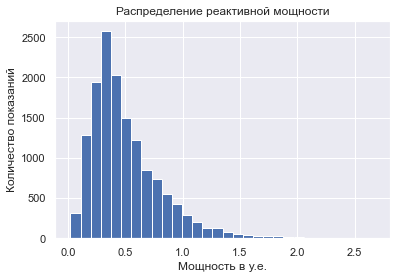

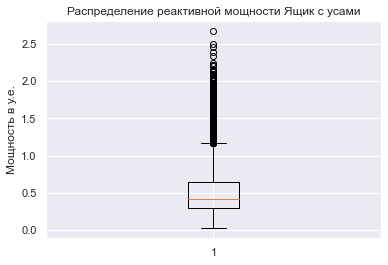

In [16]:
hist_box(data_arc['Реактивная мощность'][data_arc['Реактивная мощность'] > -700], 'Распределение реактивной мощности', 'Мощность в у.е.')

Отсечём реактивную мощность менее 0.

In [17]:
data_arc['Реактивная мощность'] = data_arc['Реактивная мощность'][data_arc['Реактивная мощность'] > 0]

Сделаем сводную таблицу по ключам и саггрегируем все колонки. Нам нужны будут колонки с минимальным временем начала нагрева дугой (старт процесса) максимальным концом нагрева дугой (конец процесса) и сумма мощностей.

In [18]:
data_arc_pivot = data_arc.pivot_table(index='key', aggfunc=['min','max','sum'])
data_arc_pivot

min                                            \
     Активная мощность  Конец нагрева дугой Начало нагрева дугой   
key                                                                
1             0.692755  2019-05-03 11:06:02  2019-05-03 11:02:14   
2             0.438063  2019-05-03 11:36:31  2019-05-03 11:34:14   
3             0.250280  2019-05-03 12:11:34  2019-05-03 12:06:54   
4             0.425692  2019-05-03 12:43:04  2019-05-03 12:39:37   
5             0.267457  2019-05-03 13:15:24  2019-05-03 13:11:13   
...                ...                  ...                  ...   
3237          0.405685  2019-08-31 22:43:17  2019-08-31 22:41:18   
3238          0.371511  2019-08-31 23:28:09  2019-08-31 23:26:18   
3239          0.205792  2019-09-01 01:29:20  2019-09-01 01:26:53   
3240          0.411601  2019-09-01 02:37:25  2019-09-01 02:35:24   
3241          0.220694  2019-09-01 04:01:35  2019-09-01 03:58:58   

                                       max                       \
     Реактивная мощность Активная мощность  Конец нагрева дугой   
key                                                               
1               0.414397          1.659363  2019-05-03 11:28:37   
2               0.283043          1.296415  2019-05-03 11:53:18   
3               0.155901          1.062053  2019-05-03 12:32:19   
4               0.268482          1.220955  2019-05-03 12:57:50   
5               0.181992          1.621665  2019-05-03 13:33:55   
...                  ...               ...                  ...   
3237            0.320431          1.060122  2019-08-31 23:03:48   
3238            0.309811          1.017459  2019-08-31 23:41:28   
3239            0.135075          1.156764  2019-09-01 02:15:43   
3240            0.274390          0.983723  2019-09-01 03:34:08   
3241            0.145768          0.733899  2019-09-01 04:36:08   

                                                            sum  \
     Начало нагрева дугой Реактивная мощность Активная мощность   
key                                                               
1     2019-05-03 11:26:09            1.062669          4.878147   
2     2019-05-03 11:49:48            0.892914          3.052598   
3     2019-05-03 12:31:14            0.671494          2.525882   
4     2019-05-03 12:53:12            0.754719          3.209250   
5     2019-05-03 13:32:44            1.047776          3.347173   
...                   ...                 ...               ...   
3237  2019-08-31 23:01:32            0.784557          3.932467   
3238  2019-08-31 23:38:38            0.850749          2.106529   
3239  2019-09-01 02:13:38            0.725063          4.666754   
3240  2019-09-01 03:31:47            0.884585          2.984083   
3241  2019-09-01 04:34:47            0.523631          2.471447   

                          
     Реактивная мощность  
key                       
1               3.183241  
2               1.998112  
3               1.599076  
4               2.060298  
5               2.252643  
...                  ...  
3237            2.828459  
3238            1.681182  
3239            3.111617  
3240            2.483267  
3241            1.696199  

[3001 rows x 10 columns]

Переименуем солбцы

In [19]:
data_arc_pivot.columns = ['active_min', 'arc_end_min', 'arc_start_min', 'reactive_min',
                        'active_max', 'arc_end_max', 'arc_start_max', 'reactive_max', 'active_sum', 'reactive_sum']
data_arc_pivot

,active_min,arc_end_min,arc_start_min,reactive_min,active_max,arc_end_max,arc_start_max,reactive_max,active_sum,reactive_sum
key,,,,,,,,,,
1,0.692755,2019-05-03 11:06:02,2019-05-03 11:02:14,0.414397,1.659363,2019-05-03 11:28:37,2019-05-03 11:26:09,1.062669,4.878147,3.183241
2,0.438063,2019-05-03 11:36:31,2019-05-03 11:34:14,0.283043,1.296415,2019-05-03 11:53:18,2019-05-03 11:49:48,0.892914,3.052598,1.998112
3,0.250280,2019-05-03 12:11:34,2019-05-03 12:06:54,0.155901,1.062053,2019-05-03 12:32:19,2019-05-03 12:31:14,0.671494,2.525882,1.599076
4,0.425692,2019-05-03 12:43:04,2019-05-03 12:39:37,0.268482,1.220955,2019-05-03 12:57:50,2019-05-03 12:53:12,0.754719,3.209250,2.060298
5,0.267457,2019-05-03 13:15:24,2019-05-03 13:11:13,0.181992,1.621665,2019-05-03 13:33:55,2019-05-03 13:32:44,1.047776,3.347173,2.252643
...,...,...,...,...,...,...,...,...,...,...
3237,0.405685,2019-08-31 22:43:17,2019-08-31 22:41:18,0.320431,1.060122,2019-08-31 23:03:48,2019-08-31 23:01:32,0.784557,3.932467,2.828459
3238,0.371511,2019-08-31 23:28:09,2019-08-31 23:26:18,0.309811,1.017459,2019-08-31 23:41:28,2019-08-31 23:38:38,0.850749,2.106529,1.681182
3239,0.205792,2019-09-01 01:29:20,2019-09-01 01:26:53,0.135075,1.156764,2019-09-01 02:15:43,2019-09-01 02:13:38,0.725063,4.666754,3.111617


In [20]:
display(data_arc_pivot.info())
display(data_arc_pivot.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3001 entries, 1 to 3241
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   active_min     3001 non-null   float64
 1   arc_end_min    3001 non-null   object 
 2   arc_start_min  3001 non-null   object 
 3   reactive_min   3001 non-null   float64
 4   active_max     3001 non-null   float64
 5   arc_end_max    3001 non-null   object 
 6   arc_start_max  3001 non-null   object 
 7   reactive_max   3001 non-null   float64
 8   active_sum     3001 non-null   float64
 9   reactive_sum   3001 non-null   float64
dtypes: float64(6), object(4)
memory usage: 257.9+ KB


None

,active_min,reactive_min,active_max,reactive_max,active_sum,reactive_sum
count,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000
mean,0.327559,0.241911,1.160595,0.882434,3.245564,2.422138
std,0.141352,0.108046,0.462973,0.352974,1.328647,1.006905
min,0.030002,0.020806,0.298468,0.202135,0.588336,0.444437
25%,0.229628,0.164495,0.823585,0.626559,2.307564,1.729515
50%,0.310622,0.227266,1.091333,0.826435,3.092772,2.294837
75%,0.421781,0.314021,1.394180,1.065016,3.964675,2.949252
max,1.129269,0.842162,3.731596,2.676388,17.496497,12.587990


Похоже реактивная мощность приблизительно во сколько то раз всегда меньше активной. Чуть позже посмотрим распределения и корреляции.
Переведём формат времени в datetime и создадим новую фичу - сколько прошло минут от начала процесса до его конца.

In [21]:
data_arc_pivot['arc_end_min'] = pd.to_datetime(data_arc_pivot['arc_end_min'], format='%Y-%m-%d %H:%M:%S')
data_arc_pivot['arc_start_min'] = pd.to_datetime(data_arc_pivot['arc_start_min'], format='%Y-%m-%d %H:%M:%S')
data_arc_pivot['arc_end_max'] = pd.to_datetime(data_arc_pivot['arc_end_max'], format='%Y-%m-%d %H:%M:%S')
data_arc_pivot['arc_start_max'] = pd.to_datetime(data_arc_pivot['arc_start_max'], format='%Y-%m-%d %H:%M:%S')

In [22]:
data_arc_pivot['passed_time'] = (data_arc_pivot['arc_end_max'] - data_arc_pivot['arc_start_min']).dt.total_seconds().div(60).astype(int)

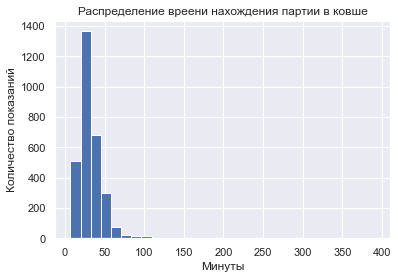

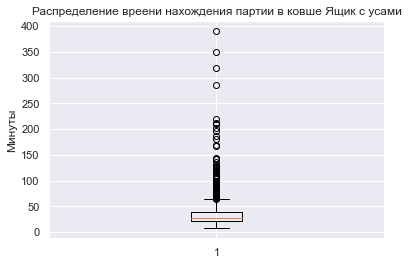

In [23]:
hist_box(data_arc_pivot['passed_time'], 'Распределение вреени нахождения партии в ковше', 'Минуты')

Среднее меньше часа, но есть и артефакты более 4 часов. Возможно они как раз помогут модели более чётко отследить зависимость изменения температуры от подаваемой мощности и длительности нахождения стали в ковше.

Посмотрим на распределение мощностей.

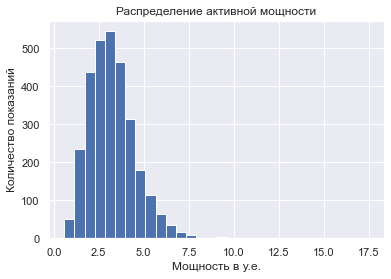

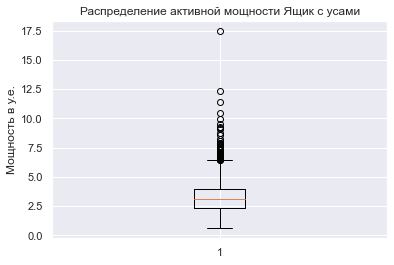

In [24]:
hist_box(data_arc_pivot['active_sum'], 'Распределение активной мощности', 'Мощность в у.е.')

Отбросим хвост с мощностью более 8

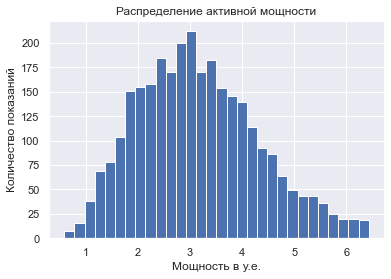

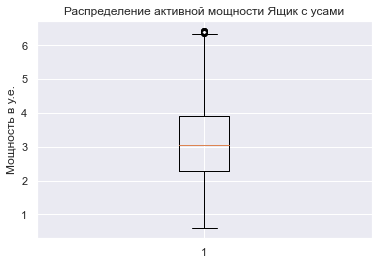

In [25]:
Q1 = data_arc_pivot['active_sum'].quantile(0.25)
Q3 = data_arc_pivot['active_sum'].quantile(0.75)
IQR = Q3 - Q1

data_arc_pivot = data_arc_pivot.query('active_sum <= (@Q3 + 1.5 * @IQR)')
hist_box(data_arc_pivot['active_sum'], 'Распределение активной мощности', 'Мощность в у.е.')

In [26]:
data_arc_pivot.shape

(2947, 11)

Потеряли всего 54 записи.

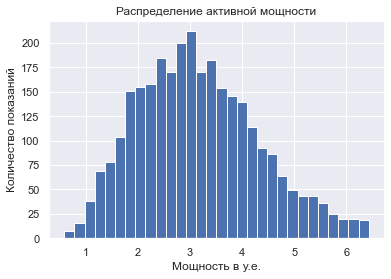

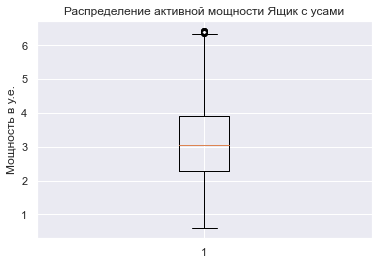

In [27]:
hist_box(data_arc_pivot['active_sum'], 'Распределение активной мощности', 'Мощность в у.е.')

Так намного лучше. Посмотрим распределения мощностей наложив их друг на друга. По идее высокая реактивная мощность также должна была исчезнуть

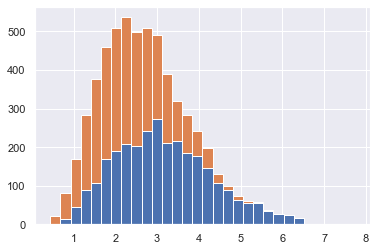

In [28]:
plt.hist(x=[data_arc_pivot['active_sum'], data_arc_pivot['reactive_sum']], bins=30, histtype='barstacked')
plt.show()

In [29]:
data_arc_pivot.corr()

,active_min,reactive_min,active_max,reactive_max,active_sum,reactive_sum,passed_time
active_min,1.000000,0.952370,0.229920,0.196655,0.178735,0.154440,-0.173141
reactive_min,0.952370,1.000000,0.193145,0.210514,0.146231,0.187805,-0.170246
active_max,0.229920,0.193145,1.000000,0.936899,0.739844,0.671560,0.141071
reactive_max,0.196655,0.210514,0.936899,1.000000,0.701521,0.734960,0.152962
active_sum,0.178735,0.146231,0.739844,0.701521,1.000000,0.942570,0.433390
reactive_sum,0.154440,0.187805,0.671560,0.734960,0.942570,1.000000,0.436501
passed_time,-0.173141,-0.170246,0.141071,0.152962,0.433390,0.436501,1.000000


Что и следовало ожидать. Корреляция более 0.9 между активной и реактивной мощностью. Оставим только время нахождения партии в ковше и суммарну активную мощность, затраченную на кажду партию.

In [30]:
data_arc_pivot = data_arc_pivot[['active_sum', 'passed_time']]
data_arc_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2947 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   active_sum   2947 non-null   float64
 1   passed_time  2947 non-null   int32  
dtypes: float64(1), int32(1)
memory usage: 57.6 KB


In [31]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [32]:
data_bulk.isnull().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [33]:
data_bulk.dropna().shape

(0, 16)

Выбросить НаНы не выйдет. Логично запонить их нулями. Нет присадки - 0 в записи.

In [34]:
data_bulk = data_bulk.fillna(0)
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [35]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [36]:
data_gas.isnull().sum()

key      0
Газ 1    0
dtype: int64

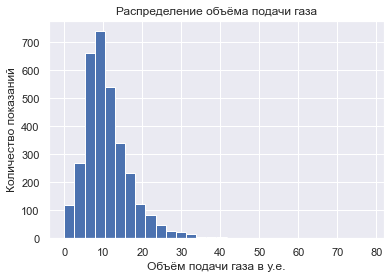

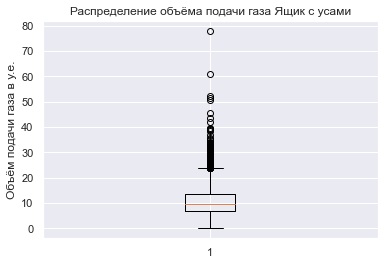

In [37]:
hist_box(data_gas['Газ 1'], 'Распределение объёма подачи газа', 'Объём подачи газа в у.е.')

Отсечём все значения более 40

In [38]:
data_gas = data_gas[data_gas['Газ 1'] < 40]

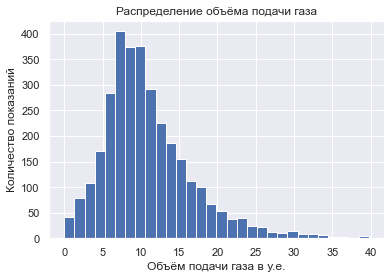

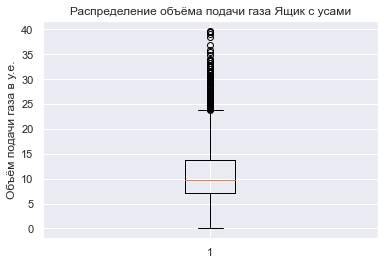

In [39]:
hist_box(data_gas['Газ 1'], 'Распределение объёма подачи газа', 'Объём подачи газа в у.е.')

Можно даже по 35, наверное.

In [40]:
data_gas = data_gas[data_gas['Газ 1'] < 35]

In [41]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [42]:
data_wire.isnull().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Также заполним нулями как и с присадками

In [43]:
data_wire = data_wire.fillna(0)
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрим что у нас происходит с таргетом

In [44]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Есть пропуски, которые мы не имее право заполнять. Скинем их.

In [45]:
data_temp = data_temp.dropna()
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13006 non-null  int64  
 1   Время замера  13006 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.4+ KB


Избавимся от всех ключей с с 1 записью, так как нам необходима температура в начале процесса и в конце.

In [46]:
valid_keys = data_temp['key'].value_counts() > 2
valid_keys = valid_keys[valid_keys == True]
data_temp = data_temp.loc[data_temp['key'].isin(valid_keys.index)]
data_temp['key'].value_counts()

1513    16
44      16
46      16
1214    16
2108    15
        ..
942      3
799      3
785      3
1739     3
1597     3
Name: key, Length: 2419, dtype: int64

Создадим сводную таблицу по ключам, которая будет включать минимальное время замера температуры партии и максимальное.

In [47]:
data_temp_pivot = data_temp.pivot_table(index='key', values='Время замера', aggfunc=['min', 'max'])
data_temp_pivot.columns = ['min_time_depos', 'max_time_depos']
data_temp_pivot

,min_time_depos,max_time_depos
key,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39
2,2019-05-03 11:37:27,2019-05-03 11:59:12
3,2019-05-03 12:13:17,2019-05-03 12:34:57
4,2019-05-03 12:52:57,2019-05-03 12:59:25
6,2019-05-03 13:49:24,2019-05-03 14:12:29
...,...,...
2494,2019-08-06 00:12:55,2019-08-06 00:23:21
2495,2019-08-06 00:35:45,2019-08-06 00:54:42
2496,2019-08-06 01:02:54,2019-08-06 01:29:52


Смерджим с ней нашу основную таблицу с температурой по минимальному времени замера. Получим температуру в начале процесса.

In [48]:
data_temp_pivot = data_temp_pivot.merge(data_temp, left_on='min_time_depos', right_on='Время замера', how='inner')
data_temp_pivot

,min_time_depos,max_time_depos,key,Время замера,Температура
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,2,2019-05-03 11:37:27,1581.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,3,2019-05-03 12:13:17,1596.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,4,2019-05-03 12:52:57,1601.0
4,2019-05-03 13:49:24,2019-05-03 14:12:29,6,2019-05-03 13:49:24,1543.0
...,...,...,...,...,...
2414,2019-08-06 00:12:55,2019-08-06 00:23:21,2494,2019-08-06 00:12:55,1585.0
2415,2019-08-06 00:35:45,2019-08-06 00:54:42,2495,2019-08-06 00:35:45,1570.0
2416,2019-08-06 01:02:54,2019-08-06 01:29:52,2496,2019-08-06 01:02:54,1554.0
2417,2019-08-06 02:03:49,2019-08-06 02:25:31,2498,2019-08-06 02:03:49,1591.0


Уберём лишнее и переименуем столбец с температурой как в стартовую

In [49]:
data_temp_pivot.drop(['key', 'Время замера'], axis=1, inplace=True)
data_temp_pivot

,min_time_depos,max_time_depos,Температура
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0
4,2019-05-03 13:49:24,2019-05-03 14:12:29,1543.0
...,...,...,...
2414,2019-08-06 00:12:55,2019-08-06 00:23:21,1585.0
2415,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0
2416,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0
2417,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0


In [50]:
data_temp_pivot.rename(columns={'Температура':'start_temp'}, inplace=True)
data_temp_pivot

,min_time_depos,max_time_depos,start_temp
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0
4,2019-05-03 13:49:24,2019-05-03 14:12:29,1543.0
...,...,...,...
2414,2019-08-06 00:12:55,2019-08-06 00:23:21,1585.0
2415,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0
2416,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0
2417,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0


Проведём те же манипуляции с максимальным временем замера температуры в партии, тем самым получив таргет.

In [51]:
data_temp_pivot = data_temp_pivot.merge(data_temp, left_on='max_time_depos', right_on='Время замера', how='inner')
data_temp_pivot

,min_time_depos,max_time_depos,start_temp,key,Время замера,Температура
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1,2019-05-03 11:30:39,1613.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,2,2019-05-03 11:59:12,1602.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,3,2019-05-03 12:34:57,1599.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,4,2019-05-03 12:59:25,1625.0
4,2019-05-03 13:49:24,2019-05-03 14:12:29,1543.0,6,2019-05-03 14:12:29,1596.0
...,...,...,...,...,...,...
2414,2019-08-06 00:12:55,2019-08-06 00:23:21,1585.0,2494,2019-08-06 00:23:21,1591.0
2415,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,2495,2019-08-06 00:54:42,1591.0
2416,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,2496,2019-08-06 01:29:52,1591.0
2417,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,2498,2019-08-06 02:25:31,1594.0


Отбросим всё время, оно нам больше не нужно и переименуем столбец с температурой.

In [52]:
data_temp_pivot.drop(['Время замера', 'min_time_depos', 'max_time_depos'], axis=1, inplace=True)
data_temp_pivot

,start_temp,key,Температура
0,1571.0,1,1613.0
1,1581.0,2,1602.0
2,1596.0,3,1599.0
3,1601.0,4,1625.0
4,1543.0,6,1596.0
...,...,...,...
2414,1585.0,2494,1591.0
2415,1570.0,2495,1591.0
2416,1554.0,2496,1591.0
2417,1591.0,2498,1594.0


In [53]:
data_temp_pivot.rename(columns={'Температура':'end_temp'}, inplace=True)
data_temp_pivot

,start_temp,key,end_temp
0,1571.0,1,1613.0
1,1581.0,2,1602.0
2,1596.0,3,1599.0
3,1601.0,4,1625.0
4,1543.0,6,1596.0
...,...,...,...
2414,1585.0,2494,1591.0
2415,1570.0,2495,1591.0
2416,1554.0,2496,1591.0
2417,1591.0,2498,1594.0


In [54]:
data_temp_pivot.describe()

,start_temp,key,end_temp
count,2419.000000,2419.000000,2419.000000
mean,1588.437371,1250.246383,1595.367507
std,29.431259,720.368442,16.001813
min,1191.000000,1.000000,1541.000000
25%,1571.500000,626.500000,1587.000000
50%,1588.000000,1254.000000,1593.000000
75%,1606.000000,1874.500000,1599.000000
max,1679.000000,2499.000000,1700.000000


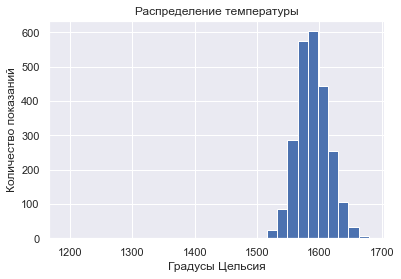

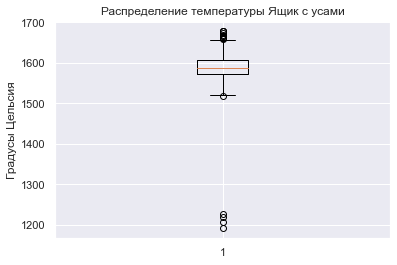

In [55]:
hist_box(data_temp_pivot['start_temp'], 'Распределение температуры', 'Градусы Цельсия')

Крайне маловероятно, что это корректные замеры. Сталь при такой температуре должна затевердеть. Отбросим всё ниже 1500

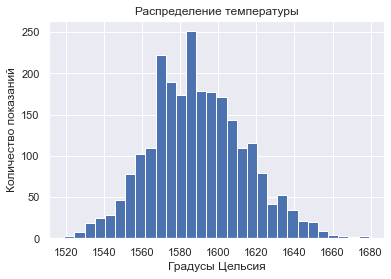

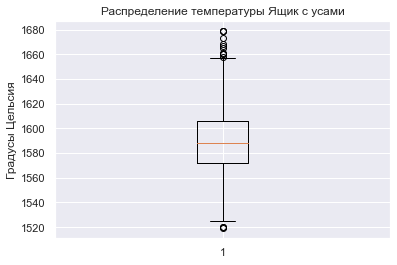

In [56]:
data_temp_pivot = data_temp_pivot[data_temp_pivot['start_temp'] > 1500]
hist_box(data_temp_pivot['start_temp'], 'Распределение температуры', 'Градусы Цельсия')

In [57]:
data_temp_pivot.describe()

,start_temp,key,end_temp
count,2415.000000,2415.000000,2415.000000
mean,1589.062526,1249.935404,1595.371429
std,25.117582,720.698594,16.014128
min,1519.000000,1.000000,1541.000000
25%,1572.000000,625.500000,1587.000000
50%,1588.000000,1254.000000,1593.000000
75%,1606.000000,1874.500000,1599.000000
max,1679.000000,2499.000000,1700.000000


Соеденим все наши таблицы по общим ключам и отбросим его затем за ненадобностью

In [58]:
data_final = data_temp_pivot.merge(data_arc_pivot, how='inner', on='key')
data_final = data_final.merge(data_bulk, how='inner', on='key')
data_final = data_final.merge(data_wire, how='inner', on='key')
data_final = data_final.merge(data_gas, how='inner', on='key')
data_final

,start_temp,key,end_temp,active_sum,passed_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1571.0,1,1613.0,4.878147,26,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,1581.0,2,1602.0,3.052598,19,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,1596.0,3,1599.0,2.525882,25,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,1601.0,4,1625.0,3.209250,18,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,1543.0,6,1596.0,3.955108,22,0.0,0.0,0.0,117.0,0.0,...,99.109917,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.273392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,1585.0,2494,1591.0,2.499038,13,0.0,0.0,0.0,162.0,0.0,...,75.042236,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.983053
2102,1570.0,2495,1591.0,3.210690,20,0.0,0.0,21.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2103,1554.0,2496,1591.0,4.203064,23,0.0,0.0,0.0,63.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2104,1591.0,2498,1594.0,3.408725,22,0.0,0.0,90.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


In [59]:
data_final.drop('key', axis=1, inplace=True)

In [60]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_temp   2106 non-null   float64
 1   end_temp     2106 non-null   float64
 2   active_sum   2106 non-null   float64
 3   passed_time  2106 non-null   int32  
 4   Bulk 1       2106 non-null   float64
 5   Bulk 2       2106 non-null   float64
 6   Bulk 3       2106 non-null   float64
 7   Bulk 4       2106 non-null   float64
 8   Bulk 5       2106 non-null   float64
 9   Bulk 6       2106 non-null   float64
 10  Bulk 7       2106 non-null   float64
 11  Bulk 8       2106 non-null   float64
 12  Bulk 9       2106 non-null   float64
 13  Bulk 10      2106 non-null   float64
 14  Bulk 11      2106 non-null   float64
 15  Bulk 12      2106 non-null   float64
 16  Bulk 13      2106 non-null   float64
 17  Bulk 14      2106 non-null   float64
 18  Bulk 15      2106 non-null   float64
 19  Wire 1

Посмотрим самые большие корреляции

In [61]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Самые большие корреляции")
print(get_top_abs_correlations(data_final, 20))

Самые большие корреляции
Bulk 9       Wire 8         0.973804
Bulk 2       Bulk 7         0.782790
             Wire 4         0.728376
Bulk 7       Wire 4         0.719968
Wire 4       Wire 7         0.640925
Bulk 12      Bulk 15        0.614836
Bulk 2       Wire 7         0.524688
             Wire 6         0.514022
Bulk 8       Bulk 9         0.499439
active_sum   passed_time    0.465286
             Bulk 12        0.451820
start_temp   active_sum     0.441854
Bulk 12      Bulk 14        0.441156
Bulk 7       Wire 6         0.428984
active_sum   Bulk 14        0.414271
passed_time  Газ 1          0.400242
Bulk 7       Wire 7         0.387336
Wire 4       Wire 6         0.381074
Bulk 2       Bulk 5         0.374649
start_temp   end_temp       0.339190
dtype: float64


Отбросим самую большую. Остальные пока оставим.

In [62]:
data_final.drop('Bulk 9', axis=1, inplace=True)

# Обучение моделей

Создадим функцию обучения модели с записью результатов в таблицу

In [63]:
SEED =42

d = pd.DataFrame(columns = ['Время обучения', 'Время предсказания', 'MAE'])
    
def ml(model_name, model, df, use_scale=True):
    X = df.drop('end_temp', axis=1)
    y = df['end_temp']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)
    
    if use_scale == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print('Масштабирование применено')
    else:
        pass

    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    start_time = time.time()
    prediction = model.predict(X_test)
    pred_time = time.time() - start_time
    MAE = mean_absolute_error(y_test, prediction)
    d.loc[model_name] = [fit_time, pred_time, MAE]
    return d

## LinearRegression

In [64]:
model = LinearRegression()

ml('LinearRegression', model, data_final)

Масштабирование применено


,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.0,5.547313


Линейная регрессия уже побила бейзлайн. Посмотрим на адекватность модели.

## DummyRegressor

In [65]:
model = DummyRegressor(strategy='mean')
ml('DummyRegressor', model, data_final)

Масштабирование применено


,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.000000,5.547313
DummyRegressor,0.000000,0.000997,7.719874


Dummy выдал метрику больше. Модель адекватна. Посмотрим остальные модели.

## CatBoostRegressor

In [66]:
model = CatBoostRegressor(random_state=SEED, verbose=0, loss_function='MAE')
ml('CatBoostTest', model, data_final)

Масштабирование применено


,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.000000,5.547313
DummyRegressor,0.000000,0.000997,7.719874
CatBoostTest,2.582768,0.002993,5.196387


CatBoost справился ещё лучше. посмотрим на важность фичей.

<BarContainer object of 27 artists>

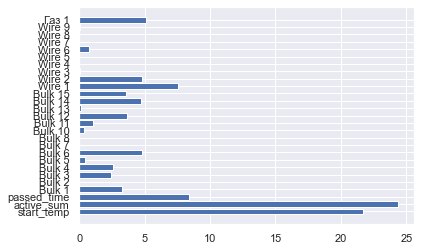

In [67]:
plt.barh(y=data_final.drop('end_temp', axis=1).columns, width=model.feature_importances_)

Попробуем отбросить, те у которых важность минимальна и снова запустим модель на базовых настройках

In [68]:
data_test = data_final.drop(['Wire 9','Wire 8','Wire 7','Wire 5',
                            'Bulk 13','Bulk 8','Bulk 2'], axis=1)

In [69]:
model = CatBoostRegressor(random_state=SEED, verbose=0, loss_function='MAE')
ml('CatBoostTest2', model, data_test)

Масштабирование применено


,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.000000,5.547313
DummyRegressor,0.000000,0.000997,7.719874
CatBoostTest,2.582768,0.002993,5.196387
CatBoostTest2,2.297026,0.001995,5.234333


In [70]:
print(model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'MAE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Exact', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 42, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MAE', 'learning_rate': 0.029999999329447743, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_le

Отлично. Метрика улучшилась. Взглянем что нам покажут остальные модели.

## XGBRegressor

In [71]:
model = XGBRegressor()
ml('XGBRegressor', model, data_test)

Масштабирование применено


,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.000000,5.547313
DummyRegressor,0.000000,0.000997,7.719874
CatBoostTest,2.582768,0.002993,5.196387
CatBoostTest2,2.297026,0.001995,5.234333
XGBRegressor,1.284409,0.002993,5.810412


XGBoost чуть медленне и метрика чуть хуже. На полном датасете (до удаление после КатБуста) метрика хуже.

## LGBMRegressor

In [72]:
model = LGBMRegressor()
ml('LGBMRegressor', model, data_final)

Масштабирование применено


,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.000000,5.547313
DummyRegressor,0.000000,0.000997,7.719874
CatBoostTest,2.582768,0.002993,5.196387
CatBoostTest2,2.297026,0.001995,5.234333
XGBRegressor,1.284409,0.002993,5.810412
LGBMRegressor,0.147606,0.001995,5.479167


In [73]:
model.feature_importances_

array([448, 450, 352,  21,   0, 142, 105,  45,  88,   0,   0,  12,  28,
       163,   0, 246, 150, 334, 109,   0,   0,   0,  12,   0,   0,   0,
       295])

In [74]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2106 entries, 0 to 2105
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   start_temp   2106 non-null   float64
 1   end_temp     2106 non-null   float64
 2   active_sum   2106 non-null   float64
 3   passed_time  2106 non-null   int32  
 4   Bulk 1       2106 non-null   float64
 5   Bulk 2       2106 non-null   float64
 6   Bulk 3       2106 non-null   float64
 7   Bulk 4       2106 non-null   float64
 8   Bulk 5       2106 non-null   float64
 9   Bulk 6       2106 non-null   float64
 10  Bulk 7       2106 non-null   float64
 11  Bulk 8       2106 non-null   float64
 12  Bulk 10      2106 non-null   float64
 13  Bulk 11      2106 non-null   float64
 14  Bulk 12      2106 non-null   float64
 15  Bulk 13      2106 non-null   float64
 16  Bulk 14      2106 non-null   float64
 17  Bulk 15      2106 non-null   float64
 18  Wire 1       2106 non-null   float64
 19  Wire 2

In [75]:
data_test2 = data_final.drop(['Wire 9','Wire 8','Wire 7','Wire 5','Wire 4',
                              'Bulk 2','Bulk 7','Bulk 8','Bulk 13'], axis=1)

In [76]:
model = LGBMRegressor()
ml('LGBMRegressor2', model, data_test2)

Масштабирование применено


,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.000000,5.547313
DummyRegressor,0.000000,0.000997,7.719874
CatBoostTest,2.582768,0.002993,5.196387
CatBoostTest2,2.297026,0.001995,5.234333
XGBRegressor,1.284409,0.002993,5.810412
LGBMRegressor,0.147606,0.001995,5.479167
LGBMRegressor2,0.138324,0.000000,5.479167


LGBMRegressor обучается больше чем в 10 раз быстрее CatBoost'а, но метрика несколько хуже. Если учесть, что она также бьёт бейзлайн, то моэет она даже лучше. А ещё интересно что неважные фичи не мешают LGBM ни в метрике, ни в скорости.

Попробуем улучшить метрику у CatBoost и у LGBM.

## GridSearch LGBM

In [77]:
def gs(model, df, grid=False, use_scale=True):
    X = df.drop('end_temp', axis=1)
    y = df['end_temp']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)
    if use_scale == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print('Масштабирование применено')
    else:
        pass
    grid_search = GridSearchCV(model, param_grid=grid, cv = 5, verbose=1,  scoring='neg_median_absolute_error')
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

In [78]:
model = LGBMRegressor()
grid = {'learning_rate': [0.01,0.03,0.1],
       'n_estimators': [300,500,700,1000]}
gs(model, data_test2, grid=grid)

Масштабирование применено
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   53.6s finished


{'learning_rate': 0.01, 'n_estimators': 700}

In [79]:
model = LGBMRegressor(learning_rate=0.01, n_estimators=1000)
ml('LGBMRegressor_after_GS', model, data_test2)

Масштабирование применено


,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.000000,5.547313
DummyRegressor,0.000000,0.000997,7.719874
CatBoostTest,2.582768,0.002993,5.196387
CatBoostTest2,2.297026,0.001995,5.234333
XGBRegressor,1.284409,0.002993,5.810412
LGBMRegressor,0.147606,0.001995,5.479167
LGBMRegressor2,0.138324,0.000000,5.479167
LGBMRegressor_after_GS,1.670540,0.016947,5.472908


Немного улучшили метрику у LGBM, но потеряли в скорости обучения

## GridSearch CatBoost

In [80]:
model = CatBoostRegressor(random_state=SEED, verbose=0, loss_function='MAE')
grid = {'learning_rate': [0.02,0.03,0.04,0.1],
       'n_estimators': [700,1000,1500]}
grid_search_result = model.grid_search(grid, 
                                       X=data_test.drop('end_temp', axis=1), 
                                       y=data_test['end_temp'], 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 7.985178121
bestIteration = 699

0:	loss: 7.9851781	best: 7.9851781 (0)	total: 2.27s	remaining: 24.9s

bestTest = 7.780994084
bestIteration = 694

1:	loss: 7.7809941	best: 7.7809941 (1)	total: 4.12s	remaining: 20.6s

bestTest = 7.761875412
bestIteration = 699

2:	loss: 7.7618754	best: 7.7618754 (2)	total: 5.98s	remaining: 17.9s

bestTest = 7.620204192
bestIteration = 353

3:	loss: 7.6202042	best: 7.6202042 (3)	total: 7.62s	remaining: 15.2s

bestTest = 7.88816236
bestIteration = 985

4:	loss: 7.8881624	best: 7.6202042 (3)	total: 10.1s	remaining: 14.2s

bestTest = 7.712951994
bestIteration = 999

5:	loss: 7.7129520	best: 7.6202042 (3)	total: 12.5s	remaining: 12.5s

bestTest = 7.735269328
bestIteration = 998

6:	loss: 7.7352693	best: 7.6202042 (3)	total: 15s	remaining: 10.7s

bestTest = 7.620204192
bestIteration = 353

7:	loss: 7.6202042	best: 7.6202042 (3)	total: 17.6s	remaining: 8.78s

bestTest = 7.837276964
bestIteration = 1492

8:	loss: 7.8372770	best: 7.6202042 (3)	total:

In [81]:
model = CatBoostRegressor(random_state=SEED, verbose=0, learning_rate=0.1, n_estimators=1000)
ml('CatBoost_after_GS', model, data_test)

Масштабирование применено


,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.000000,5.547313
DummyRegressor,0.000000,0.000997,7.719874
CatBoostTest,2.582768,0.002993,5.196387
CatBoostTest2,2.297026,0.001995,5.234333
XGBRegressor,1.284409,0.002993,5.810412
LGBMRegressor,0.147606,0.001995,5.479167
LGBMRegressor2,0.138324,0.000000,5.479167
LGBMRegressor_after_GS,1.670540,0.016947,5.472908
CatBoost_after_GS,2.021502,0.002992,5.353045


# Итог

Все модели успешно побили бейзлайн. Лучше всех показал себя CatBoost и LGBM. У первого метрика немногим лучше, у второго скорость. Модели адекватны. Вероятно, если ещё немного поработать с данными, можно несколько улучшить метрику, но поставленную задачу мы выполнили.

# Отчёт по решению

<b><u>План работы</u></b>
1. Предобработка данных
    1. Необходимо удалить все ключи с 1 записью или имеющие менее 2 замеров температуры.
    2. Выделить стартовую температуру (после первого замера) как фичу, а последнюю как таргет.
    3. Возможно стоит выделить как фичу время нахождения партии в ковше
    4. Сгрупировать таблицу с мощностями с агрегирующей функцией (видимо суммой)
    5. Заполнить пустоты. Булк и вайр вероятно заполнить нулями.
    6. Смерджить все таблицы по ключам
    7. Проверить все фичи на мультиколлинеарность. Взять на заметку фичи с высокой корреляцией.
2. Обучение моделей
    1. Выделить тест и трейн
    2. Обучить модели: CatBoost, XGBoost, LGBMRegressor, LinearRegression
    3. Проверить важность фичей. Попробовать без неважных фичей, вспоминая пункт 1.G.
    4. Обучить несколько моделей. Выбрать лучшую. Подобрать гиперпараметры.
3. Валидация результатов
    1. Проверка модели на адекватность
    2. Выводы графиков обучения модели
    
<b><u>Отчёт по плану</u></b>
1. Предобработка данных
    1. Все ключи с одним наблюдением успешно удалены. Их оказалось не так много. Менее 5%.
    2. Температуру выделили исходя из времени замера. Минимальное время замера в ключе - стартовая температура, максимальное - целевая температура.
    3. Так же успешно выделено время между первым и последним замерами в каждом ключе что, как показал опрос среди коллег, повысило метрику
    4. Выделили суммарную активную мощность по каждому ключу. От реактивной отказались из-за сильной корреляции.
    5. Наны в таблицах с присадками и проволокой заполнили нулями, посчитав что если проставлен Нан - присадку/проволоку не добавляли, следовательно ноль логичен. В таблице с газом Нанов не нашлось.
    6. Все таблицы успешно были смерджены по общим ключам. Получилось 2137 записей.
    7. Далее вся таблица была провререна на мультиколлинеарность. Отброшена одна фича с корреляцие выше 0.9
2. Обучение моделей
    1. Создали функцию, принимающую на входе модель, название модели и датасет, делившую датасет на трейн и тест, обучающую модель, делающую предсказание и записывающую необходимую нам метрику (MAE) и скорость отработки модели в таблицу.
    2. Обучили все 4 модели на штатных настройках, сразу же проверили их на адекватность сравним с Dummy. Все модели адекватные.
    3. Проверили важность фичей на моделях CatBoost и LGBM. Неважные фичи несколько отличались, поэтому обучили каждую модель на своём датасете. CatBoost улучшений результатов метрики не показал, но выдал быстрее обучение. LGBM без изменений.
    4. Выбрали CatBoost и LGBM как лучшие модели. Первая показывала лучшую метрику, вторая немного оставала, но сильно выигрывала в скоросоти. После пререборов гиперпараметров улучшений модели не показали.

In [82]:
display(d)

,Время обучения,Время предсказания,MAE
LinearRegression,0.003945,0.000000,5.547313
DummyRegressor,0.000000,0.000997,7.719874
CatBoostTest,2.582768,0.002993,5.196387
CatBoostTest2,2.297026,0.001995,5.234333
XGBRegressor,1.284409,0.002993,5.810412
LGBMRegressor,0.147606,0.001995,5.479167
LGBMRegressor2,0.138324,0.000000,5.479167
LGBMRegressor_after_GS,1.670540,0.016947,5.472908
CatBoost_after_GS,2.021502,0.002992,5.353045


Как видно Catboost немного выигрывает в метрике, но более чем в 10 раз медленнее LGBM. Обе модели бьют бейзлайн. Выбор зависит от необходимости скорости обучения.